In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.metrics import confusion_matrix, accuracy_score


In [2]:
# Function to generate height distributions
def generate_heights(mean, std_dev, size, label):
    heights = np.random.normal(mean, std_dev, size)
    labels = [label] * size
    return pd.DataFrame({'height': heights, 'label': labels})


In [3]:
# Function to plot histograms
def plot_histograms(female_heights, male_heights, bins=50, title_suffix=""):
    plt.hist([female_heights, male_heights], bins=bins, label=['Female', 'Male'], alpha=0.7, color=['purple', 'green'])
    plt.title(f'Height Distributions {title_suffix}')
    plt.xlabel('Height (cm)')
    plt.ylabel('Frequency')
    plt.legend(loc='upper right')
    plt.show()


In [4]:
# Function for threshold classification
def threshold_classifier(female_data, male_data, threshold):
    predictions = np.where(np.concatenate([female_data, male_data]) < threshold, 'F', 'M')
    actual = np.concatenate([['F'] * len(female_data), ['M'] * len(male_data)])
    return actual, predictions

# Function for probability-based classification
def probability_classifier(female_data, male_data, female_mean, female_sd, male_mean, male_sd):
    def classify(height):
        female_prob = norm.pdf(height, female_mean, female_sd)
        male_prob = norm.pdf(height, male_mean, male_sd)
        return 'F' if female_prob > male_prob else 'M'
    
    predictions = np.array([classify(h) for h in np.concatenate([female_data, male_data])])
    actual = np.concatenate([['F'] * len(female_data), ['M'] * len(male_data)])
    return actual, predictions

# Function for quantized classification
def quantized_classifier(female_data, male_data, interval_len):
    def quantize(data):
        intervals = np.floor(data / interval_len)
        return pd.Series(intervals).value_counts()
    
    female_quantized = quantize(female_data)
    male_quantized = quantize(male_data)
    quantized_ranges = set(female_quantized.index).union(set(male_quantized.index))
    
    predictions = []
    actual = []
    
    for interval in quantized_ranges:
        female_count = female_quantized.get(interval, 0)
        male_count = male_quantized.get(interval, 0)
        majority_label = 'F' if female_count >= male_count else 'M'
        predictions.extend([majority_label] * (female_count + male_count))
        actual.extend(['F'] * female_count + ['M'] * male_count)
    
    return np.array(actual), np.array(predictions)


In [5]:
# Function to evaluate and print confusion matrix and accuracy
def evaluate_classifier(actual, predictions, description=""):
    cm = confusion_matrix(actual, predictions, labels=['F', 'M'])
    accuracy = accuracy_score(actual, predictions)
    print(f"\n{description}")
    print("Confusion Matrix:")
    print(
        "\n" +
        "\t\tPredicted Female (F)\tPredicted Male (M)\n" +
        f"Actual Female (F)\t{cm[0, 0]:<5} (TP)\t\t{cm[0, 1]:<5} (FN)\n" +
        f"Actual Male (M)  \t{cm[1, 0]:<5} (FP)\t\t{cm[1, 1]:<5} (TN)"
    )
    print(f"\n(TP: True Positive, FN: False Negative, FP: False Positive, TN: True Negative)")
    print("Accuracy: {:.2f}%".format(accuracy * 100))
    return cm, accuracy


In [6]:
# Main function to execute experiments
def main():
    # Parameters
    female_mean = 152
    male_mean = 166
    std_devs = [2.5, 5, 7.5, 10]
    quantization_intervals = [0.001, 0.05, 0.1, 0.3, 1, 2, 5, 10]
    sample_size = 1000
    results = []
    
    for sd in std_devs:
        print(f"\n--- Standard Deviation: {sd} ---")
        
        # Generate data
        female_data = generate_heights(female_mean, sd, sample_size, 'F')['height'].values
        male_data = generate_heights(male_mean, sd, sample_size, 'M')['height'].values
        
        # Plot histograms
        plot_histograms(female_data, male_data, title_suffix=f'(SD={sd})')
        
        # Threshold-based classification
        threshold = (female_mean + male_mean) / 2
        actual, predictions = threshold_classifier(female_data, male_data, threshold)
        cm, accuracy = evaluate_classifier(actual, predictions, description=f"Threshold Classifier (Threshold = {threshold})")
        results.append({"Method": "Threshold", "SD": sd, "Interval": None, "Accuracy": accuracy})
        
        # Probability-based classification
        actual, predictions = probability_classifier(female_data, male_data, female_mean, sd, male_mean, sd)
        cm, accuracy = evaluate_classifier(actual, predictions, description="Probability Classifier")
        results.append({"Method": "Probability", "SD": sd, "Interval": None, "Accuracy": accuracy})
        
        # Quantized classification
        for interval_len in quantization_intervals:
            actual, predictions = quantized_classifier(female_data, male_data, interval_len)
            cm, accuracy = evaluate_classifier(actual, predictions, description=f"Quantized Classifier (Interval Length = {interval_len})")
            results.append({"Method": "Quantized", "SD": sd, "Interval": interval_len, "Accuracy": accuracy})
    
    # Save results to CSV
    results_df = pd.DataFrame(results)
    results_df.to_csv('classification_results.csv', index=False)
    print("\nResults saved to 'classification_results.csv'.")



--- Standard Deviation: 2.5 ---


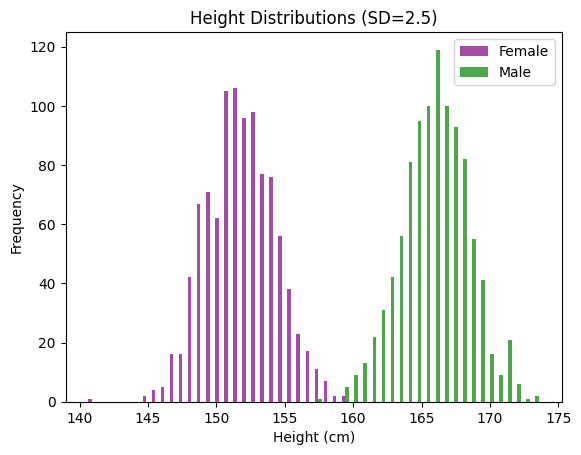


Threshold Classifier (Threshold = 159.0)
Confusion Matrix:

		Predicted Female (F)	Predicted Male (M)
Actual Female (F)	998   (TP)		2     (FN)
Actual Male (M)  	1     (FP)		999   (TN)

(TP: True Positive, FN: False Negative, FP: False Positive, TN: True Negative)
Accuracy: 99.85%

Probability Classifier
Confusion Matrix:

		Predicted Female (F)	Predicted Male (M)
Actual Female (F)	998   (TP)		2     (FN)
Actual Male (M)  	1     (FP)		999   (TN)

(TP: True Positive, FN: False Negative, FP: False Positive, TN: True Negative)
Accuracy: 99.85%

Quantized Classifier (Interval Length = 0.001)
Confusion Matrix:

		Predicted Female (F)	Predicted Male (M)
Actual Female (F)	1000  (TP)		0     (FN)
Actual Male (M)  	0     (FP)		1000  (TN)

(TP: True Positive, FN: False Negative, FP: False Positive, TN: True Negative)
Accuracy: 100.00%

Quantized Classifier (Interval Length = 0.05)
Confusion Matrix:

		Predicted Female (F)	Predicted Male (M)
Actual Female (F)	1000  (TP)		0     (FN)
Actual Male (M) 

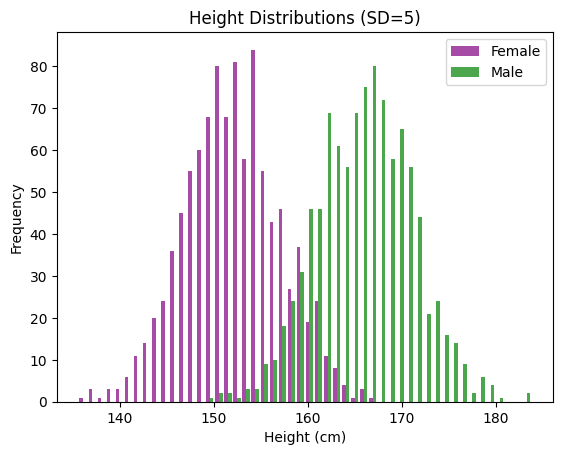


Threshold Classifier (Threshold = 159.0)
Confusion Matrix:

		Predicted Female (F)	Predicted Male (M)
Actual Female (F)	902   (TP)		98    (FN)
Actual Male (M)  	80    (FP)		920   (TN)

(TP: True Positive, FN: False Negative, FP: False Positive, TN: True Negative)
Accuracy: 91.10%

Probability Classifier
Confusion Matrix:

		Predicted Female (F)	Predicted Male (M)
Actual Female (F)	902   (TP)		98    (FN)
Actual Male (M)  	80    (FP)		920   (TN)

(TP: True Positive, FN: False Negative, FP: False Positive, TN: True Negative)
Accuracy: 91.10%

Quantized Classifier (Interval Length = 0.001)
Confusion Matrix:

		Predicted Female (F)	Predicted Male (M)
Actual Female (F)	1000  (TP)		0     (FN)
Actual Male (M)  	6     (FP)		994   (TN)

(TP: True Positive, FN: False Negative, FP: False Positive, TN: True Negative)
Accuracy: 99.70%

Quantized Classifier (Interval Length = 0.05)
Confusion Matrix:

		Predicted Female (F)	Predicted Male (M)
Actual Female (F)	952   (TP)		48    (FN)
Actual Male (M)  

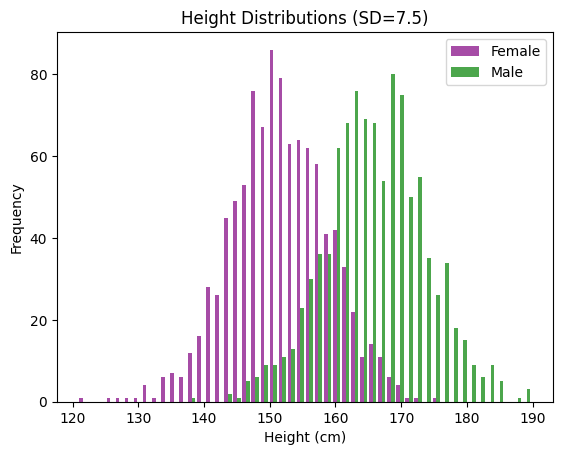


Threshold Classifier (Threshold = 159.0)
Confusion Matrix:

		Predicted Female (F)	Predicted Male (M)
Actual Female (F)	843   (TP)		157   (FN)
Actual Male (M)  	170   (FP)		830   (TN)

(TP: True Positive, FN: False Negative, FP: False Positive, TN: True Negative)
Accuracy: 83.65%

Probability Classifier
Confusion Matrix:

		Predicted Female (F)	Predicted Male (M)
Actual Female (F)	843   (TP)		157   (FN)
Actual Male (M)  	170   (FP)		830   (TN)

(TP: True Positive, FN: False Negative, FP: False Positive, TN: True Negative)
Accuracy: 83.65%

Quantized Classifier (Interval Length = 0.001)
Confusion Matrix:

		Predicted Female (F)	Predicted Male (M)
Actual Female (F)	1000  (TP)		0     (FN)
Actual Male (M)  	19    (FP)		981   (TN)

(TP: True Positive, FN: False Negative, FP: False Positive, TN: True Negative)
Accuracy: 99.05%

Quantized Classifier (Interval Length = 0.05)
Confusion Matrix:

		Predicted Female (F)	Predicted Male (M)
Actual Female (F)	909   (TP)		91    (FN)
Actual Male (M)  

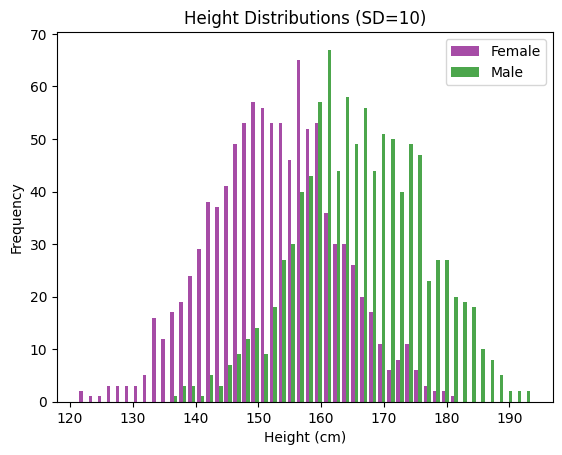


Threshold Classifier (Threshold = 159.0)
Confusion Matrix:

		Predicted Female (F)	Predicted Male (M)
Actual Female (F)	744   (TP)		256   (FN)
Actual Male (M)  	232   (FP)		768   (TN)

(TP: True Positive, FN: False Negative, FP: False Positive, TN: True Negative)
Accuracy: 75.60%

Probability Classifier
Confusion Matrix:

		Predicted Female (F)	Predicted Male (M)
Actual Female (F)	744   (TP)		256   (FN)
Actual Male (M)  	232   (FP)		768   (TN)

(TP: True Positive, FN: False Negative, FP: False Positive, TN: True Negative)
Accuracy: 75.60%

Quantized Classifier (Interval Length = 0.001)
Confusion Matrix:

		Predicted Female (F)	Predicted Male (M)
Actual Female (F)	1000  (TP)		0     (FN)
Actual Male (M)  	19    (FP)		981   (TN)

(TP: True Positive, FN: False Negative, FP: False Positive, TN: True Negative)
Accuracy: 99.05%

Quantized Classifier (Interval Length = 0.05)
Confusion Matrix:

		Predicted Female (F)	Predicted Male (M)
Actual Female (F)	883   (TP)		117   (FN)
Actual Male (M)  

In [7]:
# Run the main function
main()
